# Sistema de predicción de ventas
Queremos establecer el almacén de nuestra empresa en otra localización y necesitamos estimar el ritmo de las ventas, que desde la creación de la empresa ha ido en aumento, para los próximos meses, a fin de proveer el espacio que necesitaremos.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Paso 1: Carga del conjunto de datos


df=pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [9]:
import pandas as pd

# Asegurarse de que la columna 'date' sea de tipo datetime
df["date"] = pd.to_datetime(df["date"])

# Establecer la columna 'date' como índice
df = df.set_index("date")

# Crear la serie temporal con la columna 'sales'
ts = df["sales"]

# Ver los primeros registros
ts.head()

date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

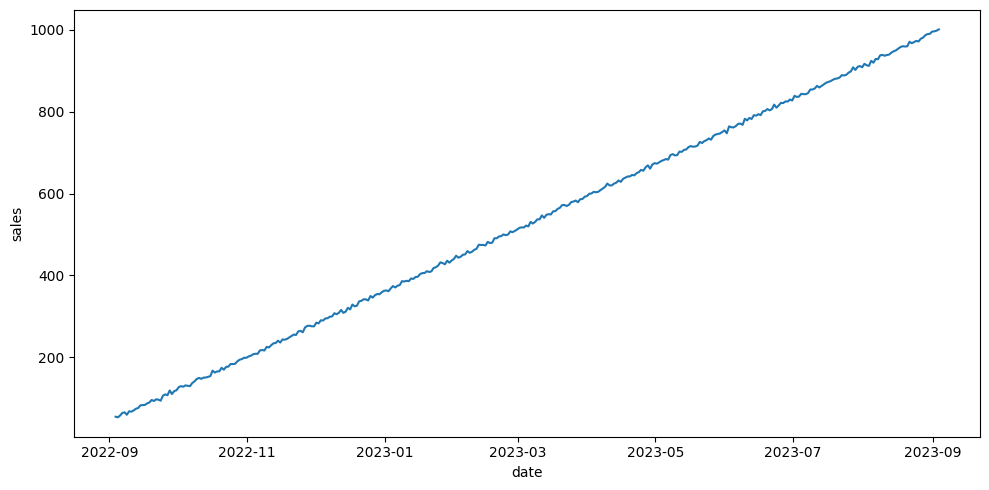

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)

plt.tight_layout()

plt.show()

### ¿Cuál es el tensor de la serie temporal?

Segun el codigo a continuacion significa que los datos de la serie temporal están registrados diariamente, es decir, hay un dato por cada día durante un año 


In [11]:
df.index.to_series().diff().value_counts()


date
1 days    365
Name: count, dtype: int64

### ¿Cuál es la tendencia?
La tendencia es claramente lineal y creciente y 

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period = 12)
decomposition

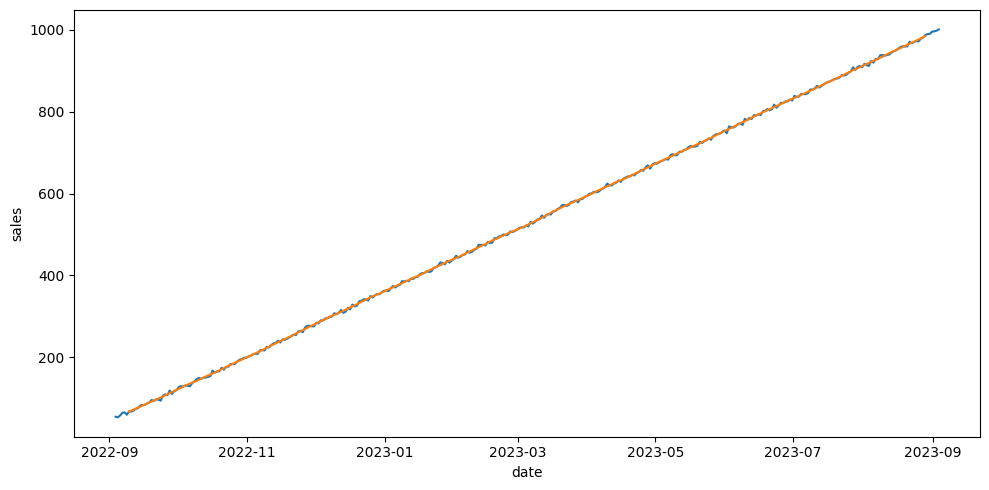

In [13]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

### ¿Es estacionaria?

En la Prueba de Dickey-Fuller podemos ver que el p-value es mayor a 0.05, esto significa que nuestra hipótesis nula será rechazada y tomaremos esta serie como no estacionaria.

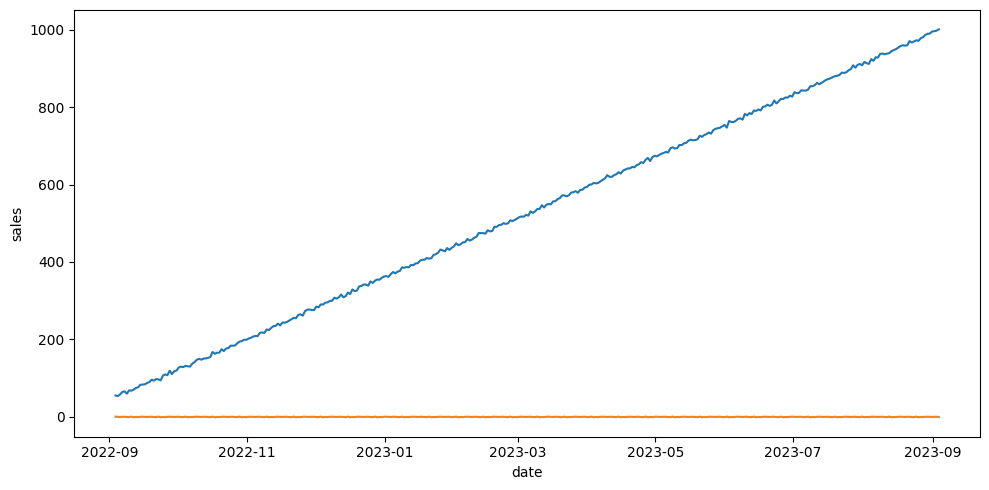

In [14]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

In [15]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

### ¿Existe variabilidad o presencia de ruido?

Observando la gráfica podemos notar que los residuos de los datos no fluctuan , asi que podemos concluir que no hay variabilidad

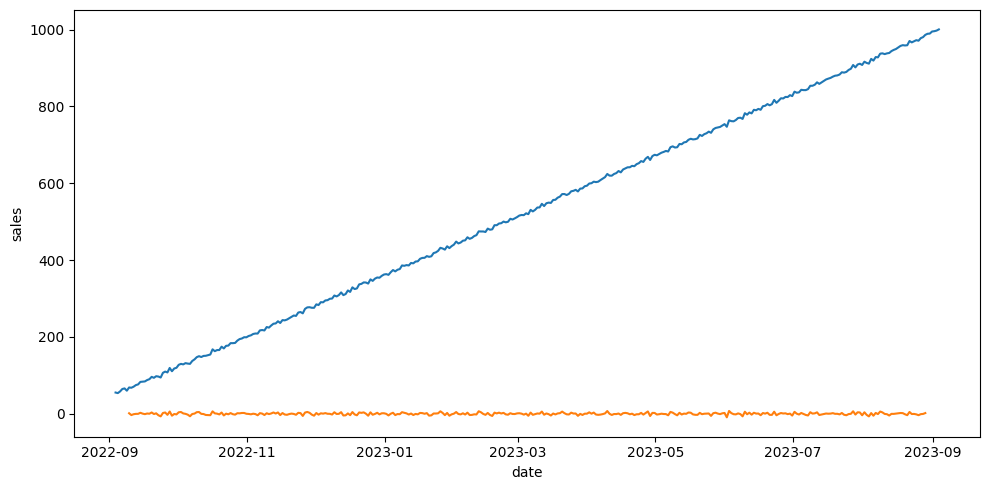

In [16]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

### Entrena un ARIMA

In [17]:
ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

In [18]:
from statsmodels.tsa.arima.model import ARIMA

# Entrenar modelo ARIMA (usa los parámetros p,d,q apropiados, ej. (1,1,1))
model = ARIMA(df['sales'], order=(1,1,1))  # ajusta según resultados
model_fit = model.fit()
print(model_fit.summary())

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  366
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1049.226
Date:                Wed, 16 Apr 2025   AIC                           2104.453
Time:                        01:51:01   BIC                           2116.152
Sample:                    09-03-2022   HQIC                          2109.102
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   2025.703      0.000       0.999       1.001
ma.L1         -0.9996      0.440     -2.271      0.023      -1.862      -0.137
sigma2        18.1480      8.139      2.230      0.0

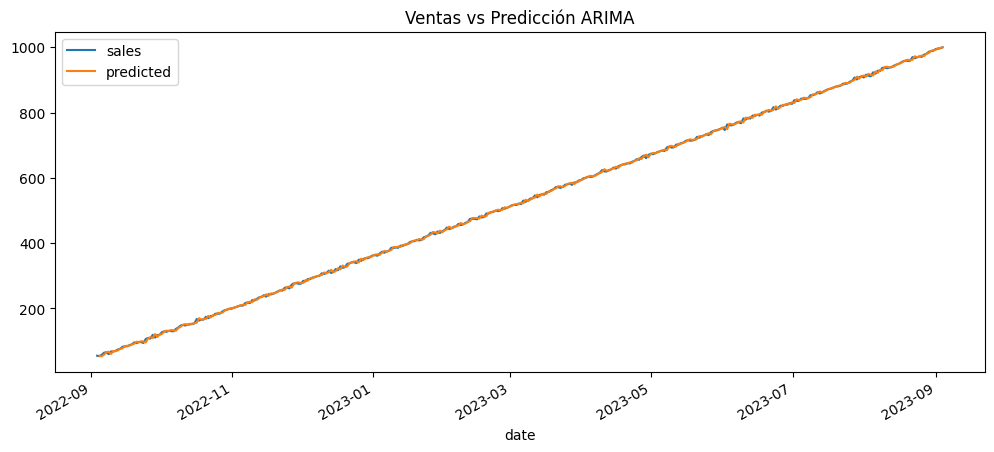

In [20]:
# Predicción sobre el mismo conjunto de datos
pred = model_fit.predict(start=1, end=len(df)-1, typ='levels')
df['predicted'] = [np.nan] + pred.tolist()

# Graficar resultados
df[['sales', 'predicted']].plot(figsize=(12,5), title="Ventas vs Predicción ARIMA")
plt.show()


In [22]:
forecast = model_fit.predict(10)
forecast

2022-09-13 17:10:08.079328     76.291910
2022-09-14 17:10:08.079328     78.108038
2022-09-15 17:10:08.079328     84.994403
2022-09-16 17:10:08.079328     85.417816
2022-09-17 17:10:08.079328     86.025629
                                 ...    
2023-08-30 17:10:08.079328    991.655287
2023-08-31 17:10:08.079328    992.168281
2023-09-01 17:10:08.079328    997.563032
2023-09-02 17:10:08.079328    998.385308
2023-09-03 17:10:08.079328    999.918265
Freq: D, Name: predicted_mean, Length: 356, dtype: float64

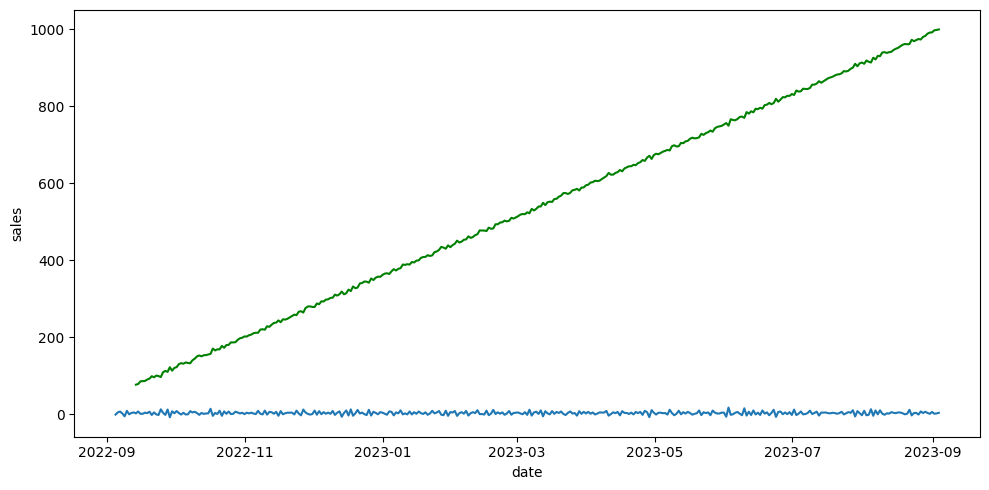

In [23]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_stationary)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

### Predice con el conjunto de test

In [24]:
# Definimos el porcentaje de datos para prueba
train_size = int(len(df) * 0.8)
train, test = df['sales'][:train_size], df['sales'][train_size:]


In [25]:
from statsmodels.tsa.arima.model import ARIMA

# Entrenamos el modelo solo con el conjunto de entrenamiento
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()


/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [26]:
# Predicción del mismo tamaño que el test
start = test.index[0]
end = test.index[-1]

forecast = model_fit.predict(start=start, end=end, typ='levels')


/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


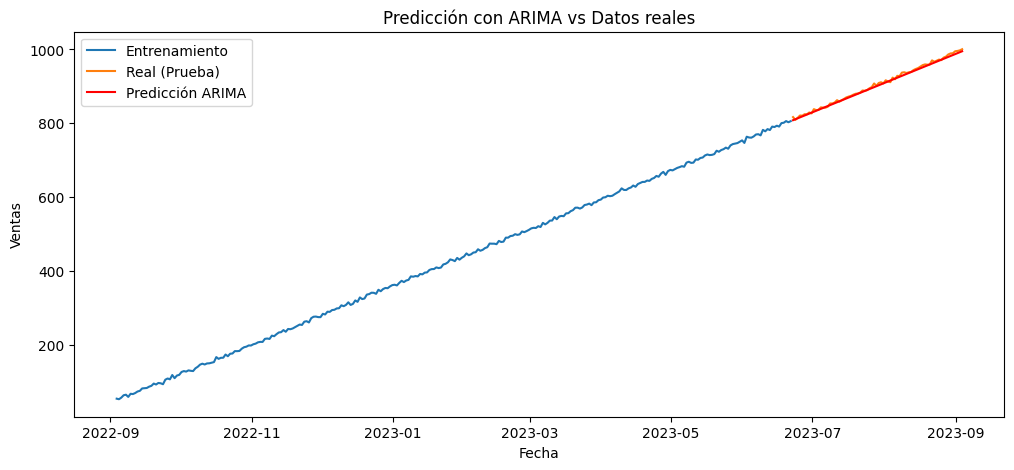

In [27]:
# Graficamos los resultados
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Real (Prueba)')
plt.plot(forecast.index, forecast, label='Predicción ARIMA', color='red')
plt.title('Predicción con ARIMA vs Datos reales')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()


In [28]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test, forecast))
print(f'RMSE del modelo ARIMA: {rmse:.2f}')


RMSE del modelo ARIMA: 4.08


In [29]:
#Guardar el modelo
from pickle import dump

dump(model_fit, open("../models/model_ventas_default_42.sav", "wb"))